In [1]:
# Load libraries
import logging

import matplotlib.pyplot as plt
import numpy as np

from klap import (
    ExponentialKernel,
    GaussianKernel,
    PolynomialKernel,
)
from klap.datasets.helper import (
    meshgrid_3d,
    plot_sphere_surface,
    spherical_harmonic,
)

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{mathtools}")
plt.rc("font", size=10, family="serif", serif="cm")
plt.rc("figure", figsize=(2, 1.5))

# Set logger
logging.basicConfig(
    level=logging.ERROR,
    format="%(asctime)s %(levelname)s %(message)s",
)

In [2]:
np.random.seed(0)
nb_trials = 10
n_test = 1000
d = 2
n = 1000
p = 100
gamma = 1

kernel = GaussianKernel(sigma=1)

def f(x):
    return np.ones_like(x[:, 0])

def f_derivative(x):
    return np.zeros_like(x)

# def f(x):
#     return x[:, 0]

# def f_derivative(x):
#     out = np.zeros_like(x)
#     out[:, 0] = 1
#     return out

# def f(x):
#     return np.cos(3*np.pi*x[:, 0])

# def f_derivative(x):
#     out = -3*np.pi*np.sin(3*np.pi*x)
#     out[:, 1:] = 0
#     return out

x = np.random.rand(n, d)
y = f(x)
t = f_derivative(x)
x_test = np.zeros((n_test, d))
x_test[:, 0] = np.linspace(0, 1, n_test)
y_test = f(x_test)

x_repr = x[:p]

K = kernel.kernel(x_repr, x)
A = K @ K.T
b = K @ y
a_plain = np.linalg.solve(A, b)

A += gamma * kernel.laplacian(x_repr, x)
T = x_repr @ t.T
T -= (x * t).sum(axis=1)
T *= K
T *= 2
b += gamma * T.sum(axis=1)
a_hermite = np.linalg.solve(A, b)

pred_hermite =  kernel.kernel(x_test, x_repr) @ a_hermite
pred_plain =  kernel.kernel(x_test, x_repr) @ a_plain

<Figure size 700x400 with 0 Axes>

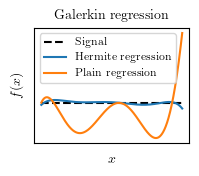

In [3]:
plt.figure(figsize=(7, 4))
# plt.scatter(x[:, 0], y)

fig, ax =plt.subplots(1, 1, figsize=(2, 1.5))
a, = ax.plot(x_test[:, 0], y_test, 'k--')
b, = ax.plot(x_test[:, 0], pred_hermite)
c, = ax.plot(x_test[:, 0], pred_plain)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r"$x$", fontsize=10)
ax.set_ylabel(r"$f(x)$", fontsize=10)
ax.set_title("Galerkin regression", fontsize=10)
ax.legend([a, b, c], ["Signal", "Hermite regression", "Plain regression"], fontsize=8)
fig.savefig("hermite.pdf", bbox_inches="tight")

#### Error to learn the constant function one in dimension d

In [4]:
nb_trials = 10
n_test = 1000
ds = [1]
# ns = [30, 100, 300, 1000, 3000, 10000]
ns = [30, 100, 300, 1000]
n_max = max(ns)

errors = np.zeros((nb_trials, len(ns), len(ds), 2))

for i_t in range(nb_trials):
    for i_d, d in enumerate(ds):
        x_max = np.random.rand(n_max, d)
        x_test = np.random.rand(n_test, d)
        y_test = np.ones(n_test)

        for i_n, n in enumerate(ns):
            x = x_max[:n]
            # x_repr = x[:int(np.sqrt(n))]
            x_repr = x[:n]
            y = np.ones(n)

            K = kernel.kernel(x_repr, x)
            A = kernel.laplacian(x_repr, x)
            A += K @ K.T
            b = K @ y
            a_hermite = np.linalg.solve(A, b)
            A = K @ K.T
            a_plain = np.linalg.solve(A, b)

            pred_hermite =  kernel.kernel(x_test, x_repr) @ a_hermite
            pred_plain =  kernel.kernel(x_test, x_repr) @ a_plain

            pred_hermite -= 1
            pred_hermite **= 2
            errors[i_t, i_n, i_d, 0] = pred_hermite.mean()
            pred_plain -= 1 
            pred_plain **= 2 
            errors[i_t, i_n, i_d, 1] = pred_plain.mean()
        print(d, flush=True, end=',')

1,1,1,1,1,1,1,1,1,1,

In [5]:
errors_mean = errors.mean(axis=0)
errors_std = errors.std(axis=0)

[]

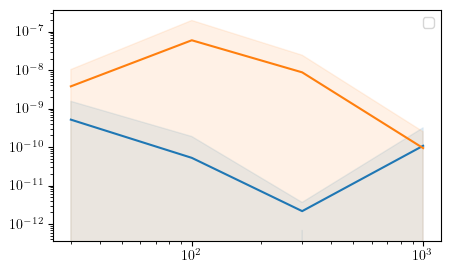

In [6]:
plt.figure(figsize=(5, 3))
for i in range(len(ds)):
    for j in range(2):
        plt.plot(ns, errors_mean[:, i, j], color=f"C{j}")
        plt.fill_between(
            ns,
            errors_mean[:, i, j] - errors_std[:, i, j],
            errors_mean[:, i, j] + errors_std[:, i, j],
            alpha=.1,
            color = f"C{j}",
        )
plt.legend()
plt.loglog()